<a href="https://colab.research.google.com/github/B21-CAP0075/Dementia-Classification/blob/development/Dementia_Care_Logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
! kaggle datasets download -d jboysen/mri-and-alzheimers

mri-and-alzheimers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_ref = zipfile.ZipFile('mri-and-alzheimers.zip', 'r')
zip_ref.extractall()
zip_ref.close()

### Cross Sectional Data

In [ ]:
df_cross = pd.read_csv('oasis_cross-sectional.csv')
df_cross = df_cross.drop(columns=['ID']) #remove unused column
df_cross = df_cross.drop_duplicates() #remove duplicate
df_cross.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [ ]:
df_cross = df_cross.drop(columns=['Delay', 'Hand', 'eTIV', 'nWBV', 'ASF']) #removed bcs user don't have this data
df_cross = df_cross.drop_duplicates()
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     283 non-null    object 
 1   Age     283 non-null    int64  
 2   Educ    231 non-null    float64
 3   SES     212 non-null    float64
 4   MMSE    231 non-null    float64
 5   CDR     231 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 15.5+ KB


In [ ]:
for column in df_cross.columns:
    if df_cross[column].dtypes == "object":
        print("Column name: {}".format(column))
        print("Number of unique entry: {}".format(len(df_cross[column].unique())))
        print("Unique entry: {}".format(df_cross[column].unique()))
        print()

print("Column name: {}".format("Educ"))
print("Number of unique entry: {}".format(len(df_cross["Educ"].unique())))
print("Unique entry: {}".format(df_cross["Educ"].unique()))
print()

print("Column name: {}".format("CDR"))
print("Number of unique entry: {}".format(len(df_cross["CDR"].unique())))
print("Unique entry: {}".format(df_cross["CDR"].unique()))
print()

Column name: M/F
Number of unique entry: 2
Unique entry: ['F' 'M']

Column name: Educ
Number of unique entry: 6
Unique entry: [ 2.  4. nan  5.  3.  1.]

Column name: CDR
Number of unique entry: 5
Unique entry: [0.  0.5 nan 1.  2. ]



In [ ]:
df_cross.describe()

,Age,Educ,SES,MMSE,CDR
count,283.000000,231.000000,212.000000,231.000000,231.000000
mean,65.318021,3.164502,2.500000,27.021645,0.290043
std,19.081514,1.308416,1.124901,3.714187,0.384861
min,18.000000,1.000000,1.000000,14.000000,0.000000
25%,54.000000,2.000000,2.000000,26.000000,0.000000
50%,71.000000,3.000000,2.000000,29.000000,0.000000
75%,80.000000,4.000000,3.000000,30.000000,0.500000
max,96.000000,5.000000,5.000000,30.000000,2.000000


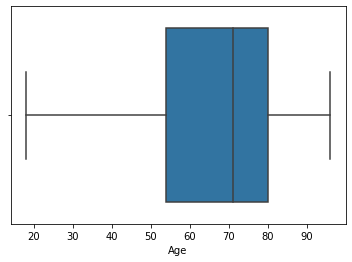

In [ ]:
sns.boxplot(x=df_cross['Age'])

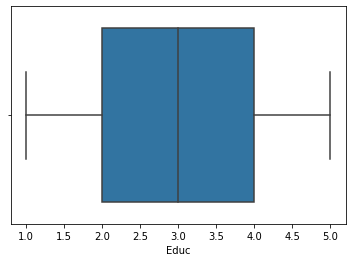

In [ ]:
sns.boxplot(x=df_cross['Educ'])

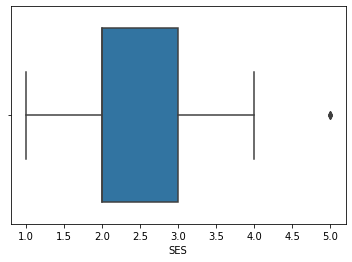

In [ ]:
sns.boxplot(x=df_cross['SES'])

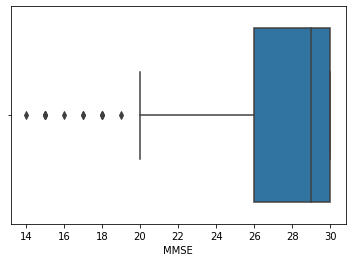

In [ ]:
sns.boxplot(x=df_cross['MMSE'])

In [ ]:
df_cross["CDR"].value_counts()

0.0    131
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

## Longitudinal Data


In [ ]:
df_long = pd.read_csv('oasis_longitudinal.csv')
df_long = df_long.drop(columns=['Subject ID', 'MRI ID']) #remove unused column
df_long.head()

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [ ]:
df_long = df_long.drop(columns=['Visit', 'MR Delay', 'Hand', 'eTIV', 'nWBV', 'ASF', 'Group']) #removed bcs user don't have this data
df_long = df_long.drop_duplicates() #remove duplicate
df_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 0 to 372
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     364 non-null    object 
 1   Age     364 non-null    int64  
 2   EDUC    364 non-null    int64  
 3   SES     345 non-null    float64
 4   MMSE    362 non-null    float64
 5   CDR     364 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 19.9+ KB


In [ ]:
for column in df_long.columns:
    if df_long[column].dtypes == "object":
        print("Column name: {}".format(column))
        print("Number of unique entry: {}".format(len(df_long[column].unique())))
        print("Unique entry: {}".format(df_long[column].unique()))
        print()

print("Column name: {}".format("Educ"))
print("Number of unique entry: {}".format(len(df_long["EDUC"].unique())))
print("Unique entry: {}".format(df_long["EDUC"].unique()))
print()

print("Column name: {}".format("CDR"))
print("Number of unique entry: {}".format(len(df_long["CDR"].unique())))
print("Unique entry: {}".format(df_long["CDR"].unique()))
print()

Column name: M/F
Number of unique entry: 2
Unique entry: ['M' 'F']

Column name: Educ
Number of unique entry: 12
Unique entry: [14 12 18 16  8 20 13  6 17 15 23 11]

Column name: CDR
Number of unique entry: 4
Unique entry: [0.  0.5 1.  2. ]



In [ ]:
df_long.describe()

,Age,EDUC,SES,MMSE,CDR
count,364.000000,364.000000,345.000000,362.000000,364.000000
mean,77.013736,14.560440,2.478261,27.287293,0.296703
std,7.609428,2.878471,1.138756,3.711225,0.376500
min,60.000000,6.000000,1.000000,4.000000,0.000000
25%,71.750000,12.000000,2.000000,27.000000,0.000000
50%,77.000000,14.000000,2.000000,29.000000,0.000000
75%,82.000000,16.000000,3.000000,30.000000,0.500000
max,98.000000,23.000000,5.000000,30.000000,2.000000


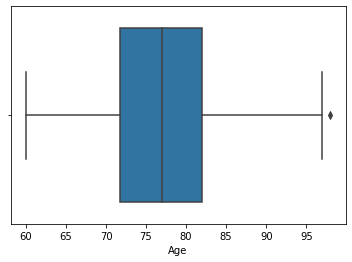

In [ ]:
sns.boxplot(x=df_long['Age'])

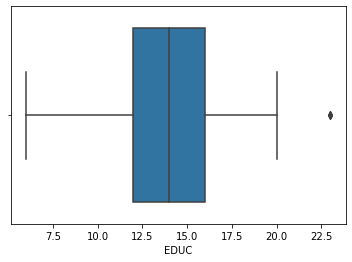

In [ ]:
sns.boxplot(x=df_long['EDUC'])

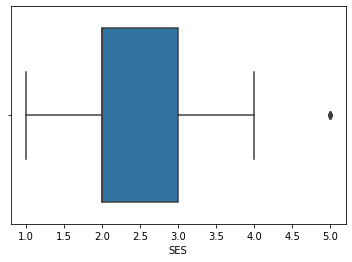

In [ ]:
sns.boxplot(x=df_long['SES'])

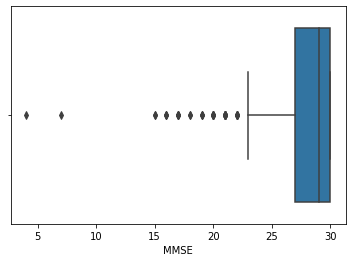

In [ ]:
sns.boxplot(x=df_long['MMSE'])

In [ ]:
df_long["CDR"].value_counts()

0.0    198
0.5    122
1.0     41
2.0      3
Name: CDR, dtype: int64

## Data Preprocessing


In [ ]:
# Converting Longituninal Educ data into Cross-Sectional Educ Data
df_long.loc[df_long.EDUC <= 6, 'EDUC'] =  1
df_long.loc[(df_long.EDUC <= 9) & (df_long.EDUC > 6), 'EDUC'] =  2
df_long.loc[(df_long.EDUC <= 12) & (df_long.EDUC > 9), 'EDUC'] =  3
df_long.loc[(df_long.EDUC <= 16) & (df_long.EDUC > 12), 'EDUC'] =  4
df_long.loc[df_long.EDUC > 16, 'EDUC'] =  5
df_long = df_long.rename(columns = {'EDUC': "Educ"})

print("Unique entry of Educ: {}".format(df_long["Educ"].unique()))

Unique entry of Educ: [4 3 5 2 1]


In [ ]:
df_dementia = pd.concat([df_long, df_cross])

df_dementia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     647 non-null    object 
 1   Age     647 non-null    int64  
 2   Educ    595 non-null    float64
 3   SES     557 non-null    float64
 4   MMSE    593 non-null    float64
 5   CDR     595 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 35.4+ KB


In [ ]:
# Change Gender into numerical value

df_dementia["M/F"] = df_dementia["M/F"].apply(lambda x: 1 if x=="M" else 0)

print("Unique entry: {}".format(df_dementia["M/F"].unique()))

Unique entry: [1 0]


In [ ]:
#Replace acute dementia with normal dementia

df_dementia['CDR'] = df_dementia['CDR'].replace([0.5,2],[0,1]) 
df_dementia["CDR"].value_counts()

0.0    521
1.0     74
Name: CDR, dtype: int64

In [ ]:
# Handling Missing Values with MICE Algorithm
missing_data= df_dementia[['Age', 'Educ', 'SES', 'MMSE']]

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(missing_data)

df_dementia[['Age', 'Educ', 'SES', 'MMSE']] = np.round(imp.transform(df_dementia[['Age', 'Educ', 'SES', 'MMSE']]))
df_dementia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     647 non-null    int64  
 1   Age     647 non-null    float64
 2   Educ    647 non-null    float64
 3   SES     647 non-null    float64
 4   MMSE    647 non-null    float64
 5   CDR     595 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 35.4 KB


In [ ]:
# Removing Missing value on Output Column
df_dementia = df_dementia.dropna(subset=['CDR'])
df_dementia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     595 non-null    int64  
 1   Age     595 non-null    float64
 2   Educ    595 non-null    float64
 3   SES     595 non-null    float64
 4   MMSE    595 non-null    float64
 5   CDR     595 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 32.5 KB


In [ ]:
dementia_label = df_dementia["CDR"].values
dementia_attributes = df_dementia.drop(columns="CDR").values

X_train, X_test, y_train, y_test = train_test_split(dementia_attributes, dementia_label, test_size=0.2, random_state=42)

lab_enc = preprocessing.LabelEncoder()
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.fit_transform(y_test)

print(len(X_train), len(X_test), len(y_train), len(y_test))

pd.DataFrame(y_train).value_counts()


476 119 476 119


0    413
1     63
dtype: int64

In [ ]:
pd.DataFrame(y_test).value_counts()

0    108
1     11
dtype: int64

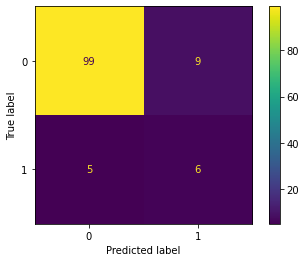

In [ ]:
model = LogisticRegression(solver='lbfgs', class_weight='balanced')
model.fit(X_train, y_train)

pred_test = model.predict(X_test)

#Ploting the confusion matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

In [ ]:
print("Accuracy: {} %".format(np.mean(score_tree['test_accuracy']) * 100))
print("Precision: {} %".format(np.mean(score_tree['test_precision_macro']) * 100))
print("Recall: {} %".format(np.mean(score_tree['test_recall_macro']) * 100))
print("F1-score: {} %".format(np.mean(score_tree['test_f1_macro']) * 100))

The f1 score for the testing data: 0.8902928370186971
